# Notes on Chapter 0 of Statistical Rethinking 2nd Edition by Richard McElreath

These notes will probably focus on the code examples, including possible translations into python/tensorflow probability.  I am neither an expert in Baysean theory nor in TensorFlow, so there may be much cleaner ways to write the code than what I have here.  Note also that if you want to use python but not need GPU acceleration, you may be better off using a more popular statistical library like SciPy or PyMC3 rather than TensorFlow probability.

First, we need to install RPy to mix R and python code in the same notebook.

In [3]:
%pip install --user rpy2

Processing /home/kms15/.cache/pip/wheels/c1/70/d8/e042e66dc766f113f6e12a02f804f4c5222281295155c91aaf/rpy2-3.3.5-cp36-cp36m-linux_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5d/94/d47b0fd5988e6b7059de05720a646a2930920fff247a826f61674d436ba4/tzlocal-2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f1/c7/72abda280893609e1ddfff90f8064568bd8bcb2c1770a9d5bb5edb2d1fea/cffi-1.14.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9f/f3/0a83558da436a081344aa6c8b85ea5b5f05071214106036ce341b7769b0b/pytest-5.4.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ae/e7/d9c3a176ca4b02024debf82342dab36efadfc5776f9c8db077e8f6e71821/pycparser-2.20-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/68/0f/41a43535b52a81e4f29e420a151032d26f08b62206840c48d14b70e53376/py-1.9.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/46/19/c5ab91b1b05cfe6

Next, we'll load RPy as an ipython extension to enable the "%%R" magic for entering raw R code

In [1]:
%load_ext rpy2.ipython

Next, lets test it:

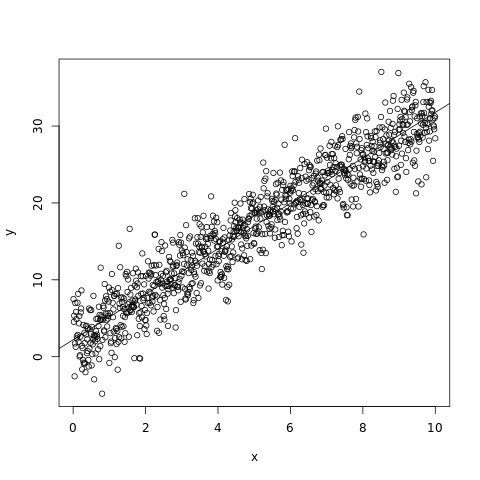

In [2]:
%%R
x = 1:1000/100
y = 3 * x + 2 + 3*rnorm(length(x))
m = lm(y ~ x, data.frame(x=x, y=y))
plot(x,y)
abline(m)

The remainder of the notebook will mostly consist of numbered R code blocks from the book and their corresponding python equivalents

### 0.1

In [3]:
%%R
print("All models are wrong, but some are useful.")

[1] "All models are wrong, but some are useful."


In [4]:
print('All models are wrong, but some are useful.')

All models are wrong, but some are useful.


### 0.2

In [5]:
%%R
x <- 1:2
x <- x*10
x <- log(x)
x <- sum(x)
x <- exp(x)
x

[1] 200


In [6]:
import tensorflow as tf
tfm = tf.math

x = tf.range(1,3, dtype=tf.float64)
x = x*10
x = tfm.log(x)
x = tfm.reduce_sum(x)
x = tf.exp(x)
x

<tf.Tensor: shape=(), dtype=float64, numpy=200.0000000000001>

### 0.3

In [7]:
%%R
print(log(0.01^200))
print(200 * log(0.01))

[1] -Inf
[1] -921.034


In [8]:
print(tfm.log(0.01**200))
print(200*tfm.log(0.01))

tf.Tensor(-inf, shape=(), dtype=float32)
tf.Tensor(-921.03406, shape=(), dtype=float32)


### 0.4

(Intercept)       speed 
 -17.579095    3.932409 


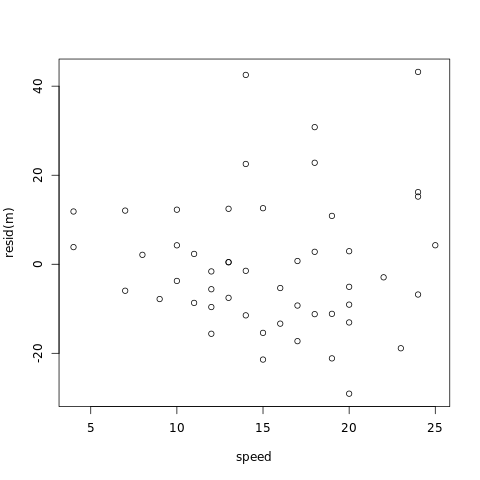

In [9]:
%%R

data(cars)
m <- lm(dist ~ speed, cars)
print(coef(m))
plot(resid(m) ~ speed, data=cars)

Loading the data is a little more painful because we have to load it from R using RPy

In [10]:
from rpy2.robjects.packages import importr, data
from matplotlib import pyplot as plt

# load the cars dataset from R
datasets = importr('datasets')
cars = data(datasets).fetch('cars')['cars']
speed = tf.constant(cars[0])
distance = tf.constant(cars[1])

There does not seem to be an obvious linear model fitting function in tensorflow. One possiblity equivalent would be to calculate it using the pseudoinverse:

tf.Tensor([-17.579098    3.9324093], shape=(2,), dtype=float32)


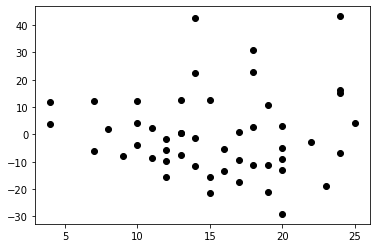

In [11]:
X_aug = tf.stack([tf.ones_like(speed), speed], axis=-1) # add a ones column to speed for the constant offset
beta = tf.tensordot(tf.linalg.pinv(X_aug), distance, axes=1)
print(beta)
plt.plot(speed, distance - tf.tensordot(X_aug, beta, axes=1), 'ok')

Alternatively, maybe the least-squares function is more obvious?:

tf.Tensor([-17.579092    3.9324088], shape=(2,), dtype=float32)


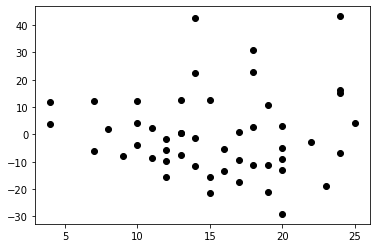

In [12]:
X_aug = tf.stack([tf.ones_like(speed), speed], axis=-1) # add a ones column to speed for the constant offset
beta = tf.linalg.lstsq(X_aug, tf.expand_dims(distance,-1), fast=False)[:,0]
print(beta)
plt.plot(speed, distance - tf.tensordot(X_aug, beta, axes=1), 'ok')

### 0.5

In [3]:
%%R

install.packages(c("coda", "mvtnorm", "devtools", "dagitty"))
library(devtools)
devtools::install_github("rmcelreath/rethinking")

R[write to console]: Installing packages into ‘/home/kms15/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/coda_0.19-3.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 73555 bytes (71 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

In [15]:
# This library is not available for python, so the R code above (or its Rpy equivalent) is sufficient